<a href="https://www.kaggle.com/code/mostafaatefffff/mura-classification-baseline?scriptVersionId=216390444" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%%bash
pip install keras-adabound
pip install tensorflow_addons

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-py3-none-any.whl size=6607 sha256=b68e3b768bf75966b869159e0b5fac8651aade3f7601ff3fc79b408236ad13b9
  Stored in directory: /root/.cache/pip/wheels/3e/bf/39/3d95847ef12aa58c15a6cc7a20f4f21ea39fcd52793e1beea0
Successfully built keras-adabound


In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from enum import Enum
import cv2
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import gc
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
from keras_adabound import AdaBound
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,SpatialDropout2D,AvgPool2D
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import DenseNet121,DenseNet169,DenseNet201
from tensorflow.keras.models import load_model
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
# define seed number to have reproducible experiments.
seed = 3352024
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Load data

This data comes as split dataset (training & validation in separate directories). Each data categories such as training & validation has sub-directories (pls see below).


```

└─train {data category}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data category}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png 
                        └───...
```

### Helper Function for loading dataset

In [4]:
def load_path(path):
    
    '''
    load MURA dataset
    '''
    dataset = [] 
    for body in os.listdir(path):
        body_part = body
        path_p = path+'/'+str(body)
        for id_p in os.listdir(path_p):
            patient_id = id_p
            path_id = path_p+'/'+str(id_p)
            for lab in os.listdir(path_id):
                if lab.split('_')[-1]=='positive': 
                    label = 1 
                elif lab.split('_')[-1]=='negative':
                    label= 0
                path_l = path_id+'/'+str(lab)
                for img in os.listdir(path_l):  
                    img_path = path_l + '/' + str(img)
                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'img_path': img_path
                        }
                    )
    return dataset

In [5]:
path = '../input/mura-v11/MURA-v1.1/train'
os.listdir(path)

['XR_WRIST',
 'XR_FINGER',
 'XR_SHOULDER',
 'XR_HAND',
 'XR_FOREARM',
 'XR_HUMERUS',
 'XR_ELBOW']

**Train set**

In [6]:
dataset = load_path(path)
df_train = pd.DataFrame(dataset)
df_train.head()

,body_part,patient_id,label,img_path
0,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
1,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
2,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
3,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
4,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...


In [7]:
dataset_test = load_path(path = '../input/mura-v11/MURA-v1.1/valid')
df_test = pd.DataFrame(dataset_test)
df_test.head()

,body_part,patient_id,label,img_path
0,XR_WRIST,patient11268,1,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
1,XR_WRIST,patient11268,1,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
2,XR_WRIST,patient11268,1,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
3,XR_WRIST,patient11302,0,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
4,XR_WRIST,patient11380,0,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...


## Data Preprocessing

#### Creating Dataset for the Model traing and generating Labels for the same.

**Training set**

In [8]:
#csv files path
path = '../input/mura-v11/MURA-v1.1'
train_image_paths_csv = "train_image_paths.csv"

In [9]:
train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
train_images_paths.columns = ['image_path']

In [10]:
train_images_paths['label'] = train_images_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
train_images_paths['category']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[2])  
train_images_paths['patientId']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
train_images_paths.head()

,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002


**Test set**

In [11]:
path = '../input/mura-v11/MURA-v1.1'
valid_image_paths_csv = "valid_image_paths.csv"
valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
valid_data_paths.columns = ['image_path']

In [12]:
valid_data_paths['label'] = valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valid_data_paths['category']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])  
valid_data_paths['dir'] =  valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
valid_data_paths['patientId']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
valid_data_paths.head()

,image_path,label,category,dir,patientId
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,valid,11186


In [13]:
train_images_paths['label_index']= train_images_paths.label

In [14]:
train_images_paths.label_index.replace('positive', 1, inplace=True)
train_images_paths.label_index.replace('negative', 0, inplace=True)
train_images_paths.head(3)

,image_path,label,category,patientId,label_index
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1


In [15]:
valid_data_paths['label_index']= valid_data_paths.label
valid_data_paths.label_index.replace('positive', 1, inplace=True)
valid_data_paths.label_index.replace('negative', 0, inplace=True)
valid_data_paths.head(3)

,image_path,label,category,dir,patientId,label_index
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1


## Image Preprocessing for creation of Dataset.

In [16]:
im_size = 256

#### Random Rotation flip

In [17]:
def random_rotation_flip(image,size = 256):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

#### Image / Dataset Loader with random rotation flip

In [18]:
def image_loader(Path, size = 224): 
    Images = []
    for path in tqdm(Path):
        try:
            image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(size,size))
            image = random_rotation_flip(image,size)
            Images.append(image)
        except Exception as e:
            print(str(e))   
    Images = np.asarray(Images).astype('float32')
    mean = np.mean(Images)
    std = np.std(Images)
    Images = (Images - mean) / std
    
    return Images

**Train set**

In [19]:
!nvidia-smi

Mon Jan  6 15:10:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
pwd

'/kaggle/working'

In [21]:
cd ..

/kaggle


In [22]:
cd input

/kaggle/input


In [23]:
cd mura-v11

/kaggle/input/mura-v11


In [24]:
X_train = image_loader(train_images_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 91.55it/s]


In [25]:
y_train = train_images_paths['label']

In [26]:
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

**Test set**

In [27]:
X_test = image_loader(valid_data_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 110.86it/s]


In [28]:
y_test = valid_data_paths['label']

In [29]:
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

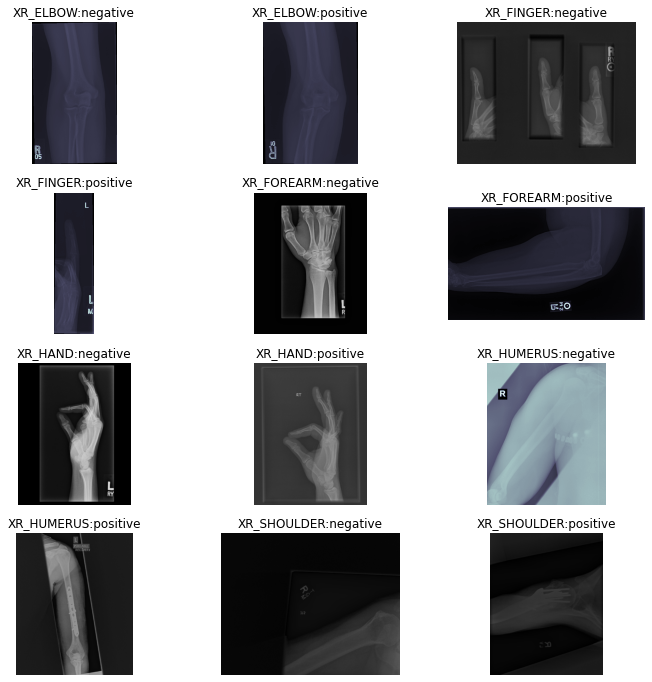

In [30]:
from skimage.io import imread
sub_df = train_images_paths.groupby(['category', 'label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['image_path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{category}:{label}'.format(**c_row))

In [31]:
train, valid = train_test_split(train_images_paths, test_size=0.2,random_state=seed)

In [32]:
test = valid_data_paths.drop(['dir'], axis=1)

## Dataset Preparation

> [NOTE : We wont be doing image augmentations in this notebook , we will do that in other Notebook to see how it impacts accuracy of models]

In [33]:
image_generator_settings = dict(
                          rescale = 1. / 255,
                          #samplewise_center = True,
                          #samplewise_std_normalization = True
                          #rotation_range = 5, 
                         )
image_generator = ImageDataGenerator(**image_generator_settings)

In [34]:
path = 'MURA-v1.1'

In [35]:
train_generator = image_generator.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe = valid,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw',target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=True,seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe = test,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = False,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest', validate_filenames=True,seed=seed)

Found 29446 non-validated image filenames.
Found 7362 validated image filenames.
Found 3197 validated image filenames.


In [36]:
CLASSES = 2
input_shape = (im_size,im_size,3)

#### Helper function for Multiple Metrics for Evaluation of our model

In [37]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="kappa", num_classes=2)
    ]

#### Custom function for Plotting results for our model in various stages

In [38]:
def plot_history(hs, epochs, metric):
    if metric=='loss': 
                label_y = 'Loss'
    elif metric=='accuracy': 
               label_y = 'Accuracy'
    elif metric=='auc': 
               label_y = 'AUC'
    else : label_y = 'kappa'
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

def print_results(model_name,epochs,hs,model_eval):
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))
    # Plot train and validation error per epoch.
    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='kappa')

#### Helper function to clear Memory Utilization enabling it to Work with GPU and standard RAM allowance in Kaggle.

In [39]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect() #garbage collection
    print("...Finished clean up...")

### RESNET152v2 Architecture

In [40]:
def resnet_builder(
        pooling="max", 
        shape=(256, 256, 3), 
        trainable_layers_after=None
    ):
    resNet = ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in resNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        resNet.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",
                                name="resnet_output_sigmoid")
    model = Sequential(
        layers=[
            resNet,
            prediction_layer
        ],
        name="resnet"
    )
    return model

234561536/234545216 [==============================] - 1s 0us/step
Epoch 1/50
461/461 [==============================] - 410s 857ms/step - loss: 0.5789 - auc: 0.7436 - accuracy: 0.7039 - kappa: 0.3626 - val_loss: 0.5498 - val_auc: 0.7882 - val_accuracy: 0.7260 - val_kappa: 0.4333
Epoch 2/50
461/461 [==============================] - 239s 518ms/step - loss: 0.5328 - auc: 0.7922 - accuracy: 0.7399 - kappa: 0.4398 - val_loss: 0.5535 - val_auc: 0.7991 - val_accuracy: 0.7316 - val_kappa: 0.4072
Epoch 3/50
461/461 [==============================] - 242s 524ms/step - loss: 0.5209 - auc: 0.8033 - accuracy: 0.7496 - kappa: 0.4628 - val_loss: 0.5281 - val_auc: 0.8029 - val_accuracy: 0.7463 - val_kappa: 0.4614
Epoch 4/50
461/461 [==============================] - 239s 518ms/step - loss: 0.5136 - auc: 0.8090 - accuracy: 0.7513 - kappa: 0.4665 - val_loss: 0.5269 - val_auc: 0.8058 - val_accuracy: 0.7414 - val_kappa: 0.4595
Epoch 5/50
461/461 [==============================] - 244s 528ms/step - loss:

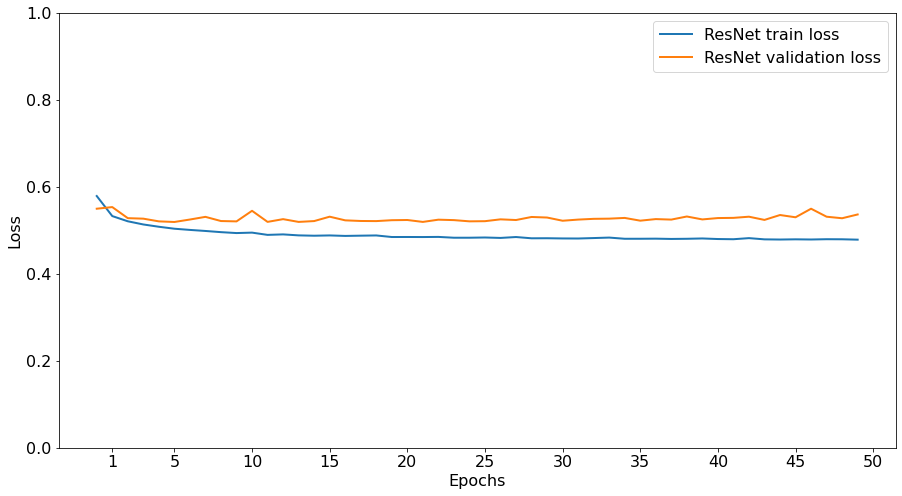

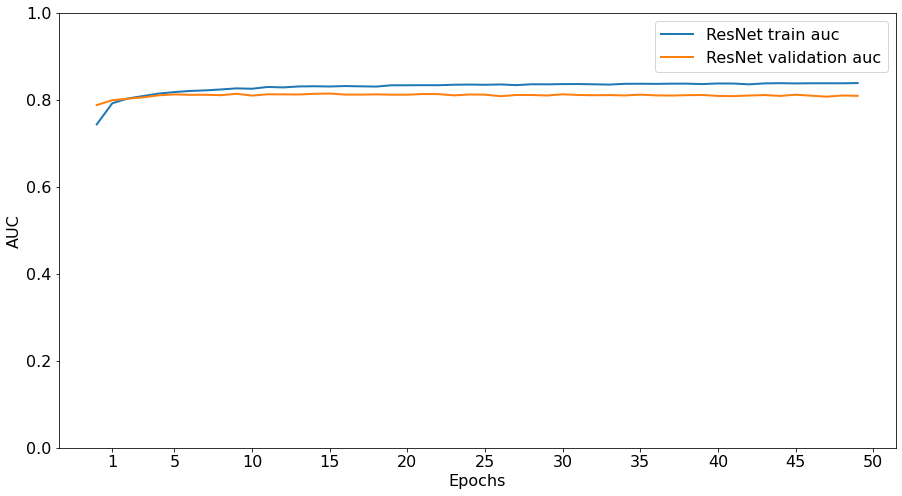

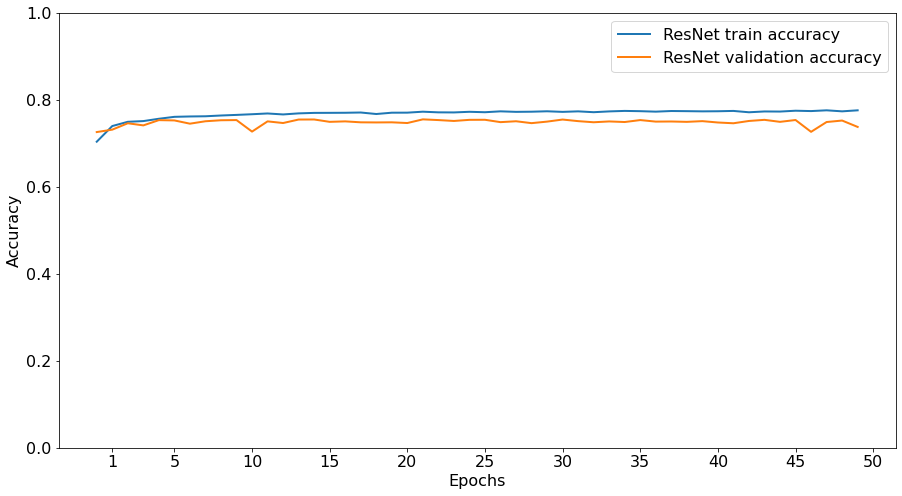

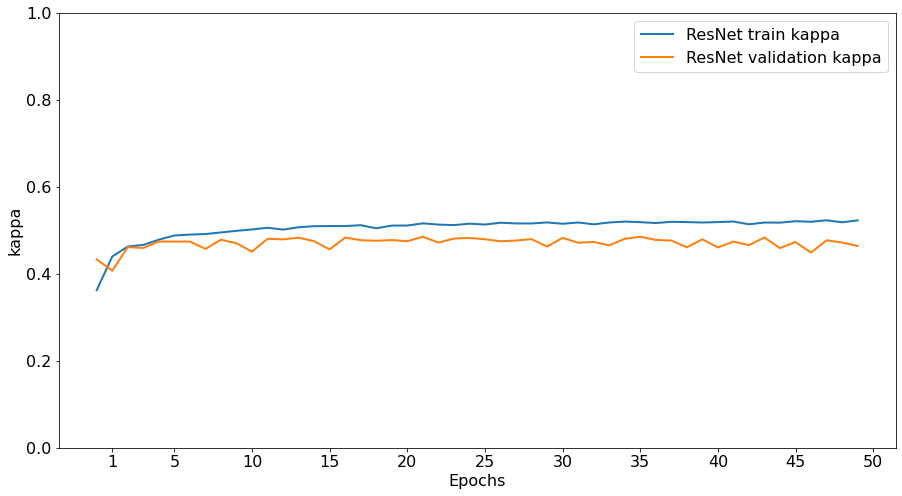

In [41]:
epochs = 50
early_stop = EarlyStopping(monitor="kappa",mode="min", patience=3, restore_best_weights=True)
resnet_model = resnet_builder(pooling='avg')
resnet_model.compile(optimizer=Adam(), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = resnet_model.fit(train_generator,validation_data = valid_generator, epochs = epochs)
print('Finished training.')
print('------------------')
resnet_model.summary()
filename = '/kaggle/working/model_5.h5'

# Evaluate on test data and show all the results.
resnet_model_eval = resnet_model.evaluate(test_generator)
clean_up(model=resnet_model)
print_results(model_name='ResNet',epochs= epochs,hs = hs, model_eval = resnet_model_eval)

In [44]:
resnet_model.save(filename)
print('>Saved %s' % filename)

>Saved /kaggle/working/model_5.h5


In [45]:
from IPython.display import FileLink

# Create a download link
FileLink('/kaggle/working/model_5.h5')


/kaggle/working/model_5.h5

In [46]:
import os 
os.getcwd()

'/kaggle/input/mura-v11'

In [49]:
os.chdir("/kaggle")

In [50]:
os.getcwd()

'/kaggle'

In [51]:
os.listdir()

['lib', 'input', 'working']

In [53]:
os.chdir('working')

In [54]:
os.listdir()

['model_5.h5']

In [55]:

# Generate a clickable download link
FileLink('model_5.h5')


/kaggle/working/model_5.h5